# Consistent Hashing

In [1]:
import hashlib
from bisect import bisect, bisect_left
from typing import Union

import matplotlib.pyplot as plt

In [2]:
def plot_hashring(hash_space, occupied_keys, item_key: int = None, node_key: int = None):
    figure = plt.figure()
    axes_1 = figure.add_axes([0, 0, 3, 1])
    axes_1.axes.get_yaxis().set_visible(False)
    plt.ylim(top=2)
    y_data = [0] * hash_space
    for k in occupied_keys:
        y_data[k] = 1

    if item_key:
        y_data[item_key] = 0.75

    barlist = axes_1.bar(range(hash_space), y_data)

    barlist[item_key].set_color('r')
    barlist[node_key].set_color('g')

    plt.show()

In [3]:
def hash_fn(data: str) -> int:
    """hash_fn creates an integer equivalent of a SHA256 hash

    data could be a string or an integer
    """
    hsh = hashlib.sha256()

    # converting data into bytes and passing it to hash function
    hsh.update(bytes(data.encode('utf-8')))

    # converting the HEX digest into equivalent integer value
    return int(hsh.hexdigest(), 16)

In [4]:
class HashRing:
    """HashRing represents Consistent HashRing. One instance of this
    class will be one instance of Consistent HashRing. The class exposes
    all the functions required to interact with the ring.
    """

    def __init__(self):
        self.keys = []          # indices taken up in the ring
        self.nodes = []         # nodes in the ring
        self.hash_space = 100   # total slots in the ring

    def _generate_key(self, data):
        """returns hash key modulo hash_space because of which it represents
        the location in the flattened hash ring where the data should reside.
        """
        return hash_fn(data) % self.hash_space

    def add_node(self, node_id: str) -> int:
        """add_node function adds a new node to the ring
        """

        # handling error when hash space is full.
        if len(self.keys) == self.hash_space:
            raise Exception("hash space is full")

        key = self._generate_key(node_id)

        # find the index where the key should be inserted in the keys store
        index = bisect(self.keys, key)

        # if we have already seen the key i.e. node already is present
        # for the same key, we raise Collision Exception
        if index > 0 and self.keys[index - 1] == key:
            raise Exception("collision occurred")

        # insert the node_id and the key at the same `index` location.
        # this insertion will keep nodes and keys sorted w.r.t keys.
        self.nodes.insert(index, node_id)
        self.keys.insert(index, key)

        return key

    def remove_node(self, node_id: str) -> None:
        """remove_node removes the node with id = node_id
        """

        # handling error when space is empty
        if len(self.keys) == 0:
            raise Exception("hash space is empty")

        key = hash_fn(node_id) % self.hash_space

        # we find the index where the key would reside in the keys
        index = bisect_left(self.keys, key)

        # if key does not exist in the array we raise Exception
        if index >= len(self.keys) or self.keys[index] != key:
            raise Exception("node does not exist")

        # now that all sanity checks are done we popping the
        # keys and nodes at the index and thus removing presence of the node.
        self.keys.pop(index)
        self.nodes.pop(index)

    def get_node(self, item: str) -> str:
        """Given an item, the function returns the node to which this
        item will lie its allegiance.
        """
        return None

    def plot(self, item: str = None) -> None:
        plot_hashring(self.hash_space, self.keys, item_key=55, node_key=57)

15
61


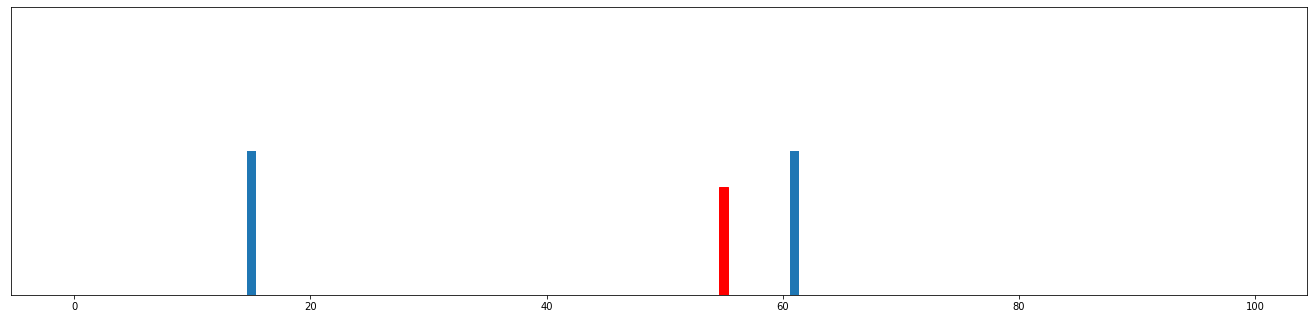

In [5]:
hr = HashRing()
print(hr.add_node("1"))
print(hr.add_node("2"))
hr.plot()